# CAICT 風機結冰預測 - Data Exploration

2017/07/20
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

In [1]:
from IPython.display import HTML
HTML('''<script>
presentation = 0;
code_show=true; 
function code_toggle() {
 if (!presentation){
     return;
 }
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


<a id='home'></a>
### Outline
[1. Modules](#load)  
[2. Input Data](#input)  
[3. Single Variable Exploration](#single)    
[4. Multi-Variable Exploration](#multi)
[5. dimension reduction](#dimen)

<a id='load'></a>
**1. Modules**

- **Python modules:**

In [20]:
%matplotlib inline
import sys
import os
import datetime
import pandas as pd
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import shutil
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
from sklearn.decomposition import PCA
from sklearn import preprocessing
from mpl_toolkits import mplot3d
import scipy.stats as stats
import pylab

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"

- ** data loading and processing modules**

In [21]:
def timerangeCheck(t, start, end):
    return (t>=start) & (t<=end)

def variable_selection(data, isTest=False):
    if isTest:
        fixed_variable = ['time','group']
    else:
        fixed_variable = ['label','event','time','group','timestamp']
    #selected_variable = ['pitch1_angle','pitch2_angle','pitch3_angle','pitch1_speed','pitch3_speed','pitch2_speed']
    selected_variable = ['pitch1_angle','pitch2_angle','pitch3_angle','pitch1_speed','pitch3_speed','pitch2_speed','power','yaw_position','environment_tmp']
    variable = selected_variable + fixed_variable 
    data = data[variable]
    return data

def load_resample_data(id, policy=1):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_y = data_resample['label']
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y

def load_resample_data_split(id, split_case, policy=1):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)
    data_resample_train = data_resample[data_resample['event']<split_case]
    data_resample_valid = data_resample[data_resample['event']>=split_case]
    train_X = data_resample_train.drop(['label','time','group','timestamp','event'], axis=1).values
    train_y = data_resample_train['label']
    valid_X = data_resample_valid.drop(['label','time','group','timestamp','event'], axis=1).values
    valid_y = data_resample_valid['label']
    train_Y = np.eye(train_y.unique().size)[train_y.values.astype(int)]
    valid_Y = np.eye(valid_y.unique().size)[valid_y.values.astype(int)]
    return data_resample, train_X, train_Y, train_y, valid_X, valid_Y, valid_y, train_desc, valid_desc


- ** event information modules**

In [22]:
def get_event_info(data, event_id):
    print('event:',event_id)
    evtdata = data[data['event']==event_id]
    evtdata_nor=evtdata[evtdata['label']==0]
    evtdata_abnor=evtdata[evtdata['label']==1]
    evtdata_unknown=evtdata[evtdata['label']==2]
    nor_min = ((evtdata_nor['time'].iloc[-1] - evtdata_nor['time'].iloc[0]).total_seconds())/60
    abnor_min = ((evtdata_abnor['time'].iloc[-1] - evtdata_abnor['time'].iloc[0]).total_seconds())/60
    unknown_min = 0 if evtdata_unknown.empty else ((evtdata_unknown['time'].iloc[-1] - evtdata_unknown['time'].iloc[0]).total_seconds())/60    
    event_msg_df = pd.DataFrame({'type':['normal','unknown','abnormal']})
    event_msg_df['minute']=[nor_min,unknown_min,abnor_min]
    event_msg_df['hour']=[nor_min/60,unknown_min/60,abnor_min/60]
    event_msg_df['qty']=[len(evtdata_nor),len(evtdata_unknown),len(evtdata_abnor)]
    return event_msg_df

- ** single variable chart modules **

In [57]:
def QQ_plot(data, varlist):
    data_qq_nor = data[data['label']==0]
    data_qq_abnor = data[data['label']==1]
    data_qq_unknown = data[data['label']==2]
    desc = data.describe()
    for idx, var in enumerate(varlist):
        dummy = plt.figure(figsize=[15,5])
        y_min=desc[var]['min']
        y_max=desc[var]['max']

        dummy = plt.subplot(1,4,1)
        res =stats.probplot(data[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' All')
        dummy = plt.ylim(y_min, y_max)

        dummy = plt.subplot(1,4,2)
        res =stats.probplot(data_qq_nor[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' Normal')
        dummy = plt.ylim(y_min, y_max)

        dummy = plt.subplot(1,4,3)
        res =stats.probplot(data_qq_abnor[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' Failure')
        dummy = plt.ylim(y_min, y_max)

        dummy = plt.subplot(1,4,4)
        res =stats.probplot(data_qq_unknown[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' Unknown')
        dummy = plt.ylim(y_min, y_max)
        pylab.show()


    
def trend_chart(data, event_id, varlist=['label'], tsrange=None, split=False, ma=300):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        if tsrange is not None:
            evtdata = evtdata[(evtdata['timestamp']>tsrange[0]) & (evtdata['timestamp']<tsrange[-1])]
        evtdata_nor=evtdata[evtdata['label']==0]
        evtdata_abnor=evtdata[evtdata['label']==1]
        evtdata_unknown=evtdata[evtdata['label']==2]

        for var in varlist:
            dummy = plt.figure(figsize=[17,2])
            dummy = plt.plot(evtdata_nor['timestamp'],evtdata_nor[var], color='green',marker='o',ms=1,label='pass')
            dummy = plt.plot(evtdata_unknown['timestamp'],evtdata_unknown[var], color='gray',marker='o',ms=1, label='unknown')
            dummy = plt.plot(evtdata_abnor['timestamp'],evtdata_abnor[var], color='red',marker='o',ms=1, label='fail')
            plt.title('event '+str(eid)+'\t'+var,fontsize='large')
            #dummy = plt.plot(evtdata['timestamp'],pd.rolling_mean(evtdata[var],ma), color='cyan',lw=0.8, label='ma')
            #dummy = plt.plot(evtdata['timestamp'],pd.rolling_std(evtdata[var],ma), color='yellow',lw=0.8)
            dummy = plt.plot(evtdata['timestamp'],pd.ewma(evtdata[var], halflife=ma), color='yellow',lw=0.8, label='ewma')
            data_diff = evtdata[var] - evtdata[var].shift() 
            dummy = plt.plot(evtdata['timestamp'],data_diff, color='cyan',lw=0.8, label='diff')
            plt.legend()
            if split: 
                dummy = plt.figure(figsize=[17,2])
                dummy = plt.plot(evtdata_nor['timestamp'],evtdata_nor[var], color='green',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'normal')
                dummy = plt.figure(figsize=[17,2])
                dummy = 0 if evtdata_unknown.empty else plt.plot(evtdata_unknown['timestamp'],evtdata_unknown[var], color='gray',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'unknown')
                dummy = plt.figure(figsize=[17,2])
                dummy = plt.plot(evtdata_abnor['timestamp'],evtdata_abnor[var], color='red',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'failure')
        dummy = plt.show()



        
def box_plot(data, event_id, varx, varylist,fun=sns.violinplot):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varylist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        dummy = plt.figure(figsize=[11,4])
        for idx, vary in enumerate(varylist):   
            plt.subplot(1,varsize,idx+1)
            fun(x=varx, y=vary, data=evtdata)
            plt.xlabel(varx)
            plt.ylabel(vary)
            plt.title('event '+str(eid))
        plt.tight_layout()
        plt.show()
            
        
def dist_plot(data,event_id, varlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varlist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        dummy = plt.figure(figsize=[11,4])
        for idx, var in enumerate(varlist):
            plt.subplot(1,varsize,idx+1)
            evtdata_nor=evtdata[evtdata['label']==0][var]
            evtdata_abnor=evtdata[evtdata['label']==1][var]
            evtdata_unknown=evtdata[evtdata['label']==2][var]
            sns.distplot(evtdata_nor, label='pass', color='g') 
            sns.distplot(evtdata_abnor, label='failure', color='r') 
            dummy = 0 if evtdata_unknown.empty else sns.distplot(evtdata_unknown, label='unknown', color='gray') 
            plt.legend()
            plt.title('event '+str(eid))
        plt.tight_layout()
        plt.show()

def line_chart(data, event_id, varlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    plt.figure(figsize=[17,3])
    for eid in event_id:
        evtdata = data[data['event']==eid]
        label_s = evtdata['label']
        evtdata = evtdata[varlist]
        evtdata_nor=evtdata[label_s==0]
        evtdata_abnor=evtdata[label_s==1]
        #evtdata_unknown=evtdata[label_s==2]
        for index, row in evtdata_nor.iterrows():
            dummy = row.plot(color='green', alpha=0.3, lw=0.2)
        for index, row in evtdata_abnor.iterrows():
            dummy = row.plot(color='red', alpha=0.3, lw=0.2)
       # for index, row in evtdata_unknown.iterrows():
       #     dummy = row.plot(color='gray', alpha=0.3, lw=0.2)
        plt.title('event '+str(eid))
        plt.show()

- ** Mmltiple var chart modules**

In [140]:
def scatter_plot(data, event_id, vary, varxlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varxlist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        desc = data.describe()
        y_min=desc[vary]['min']
        y_max=desc[vary]['max']
        dummy = plt.figure(figsize=[17,5])
        for idx, varx in enumerate(varxlist):
            plt.subplot(1,varsize,idx+1)
            #plt.figure(figsize=[10,8])
            plt.scatter(varx, vary, c='label', edgecolor='none', marker='*', alpha=0.6, data=evtdata,norm=norm, cmap=cmap)
            #plt.colorbar()
            #x_min=desc[varx]['min']
            #x_max=desc[varx]['max']
            #plt.xlim(x_min, x_max)
            #plt.ylim(y_min, y_max)
            plt.title('event '+str(eid))
            plt.xlabel(varx)
            plt.ylabel(vary)
        #plt.tight_layout()
        plt.show()

def sactter_3d(data, event_id, varx, vary, varzlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varzlist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        dummy = plt.figure(figsize=[15,5])
        for idx, varz in enumerate(varzlist):
            #plt.figure(figsize=[10,8])
            ax = plt.subplot(1,varsize,idx+1, projection='3d')
            ax.scatter3D(evtdata[varx],evtdata[vary],evtdata[varz],c=evtdata['label'], cmap=cmap, norm=norm)
            ax.set_xlabel(varx)
            ax.set_ylabel(vary)
            ax.set_zlabel(varz)
            plt.title('event:'+str(eid))
        plt.show()

<a id='input'></a>
** 2. Input Data **

In [16]:
print('data resample policy:')
filename = 'data/resample_policy_desc.csv'
policy_desc = pd.read_csv(filename)
policy_desc

data resample policy:


policy_desc
0                                        no resample
1  event data + normal data (before and after eve...
2  half event data + normal data (before event on...
3      event data + normal data (before event only)

- data resample policy
    - policy=0: no resample
    - policy=1: event data + normal data (before and after event )
    - policy=2: half event data + normal data (before event only)  
    - policy=3: event data + normal data (before event only)  


- ** normalize**

In [23]:
#resampled data 
data_raw, _, _, _ = load_resample_data(id=15,policy=3)
non_data_cols = ['label','time','group','timestamp','event']
data_pure = data_raw.drop(non_data_cols, axis=1)

#x = data_tmp.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
standard_scaler = preprocessing.StandardScaler()
data_scaled = standard_scaler.fit_transform(data_pure)
data_scaled = pd.DataFrame(data_scaled, columns = data_pure.columns)
for col in non_data_cols:
    data_scaled[col] = data_raw[col]

data = data_scaled
cols=data.columns
cols = cols.drop(['time','timestamp','group','event'])
pd.DataFrame(cols).transpose()
events = data['event'].unique()

0                1      2               3                    4   \
0  wind_speed  generator_speed  power  wind_direction  wind_direction_mean   

             5          6             7             8             9   \
0  yaw_position  yaw_speed  pitch1_angle  pitch2_angle  pitch3_angle   

             10            11            12               13               14  \
0  pitch1_speed  pitch2_speed  pitch3_speed  pitch1_moto_tmp  pitch2_moto_tmp   

                15     16     17               18       19              20  \
0  pitch3_moto_tmp  acc_x  acc_y  environment_tmp  int_tmp  pitch1_ng5_tmp   

               21              22             23             24  \
0  pitch2_ng5_tmp  pitch3_ng5_tmp  pitch1_ng5_DC  pitch2_ng5_DC   

              25     26  
0  pitch3_ng5_DC  label

- ** data info:**

In [24]:
data['time']=pd.to_datetime(data['time'])
data['label'].value_counts()
data_failure = data[data['label']==1]
data_normal = data[data['label']==0]
msg = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(data_normal), j=len(data_normal)/len(data),k=len(data_failure),m=len(data_failure)/len(data), n=len(data))   
print(msg,'\n')
#print(data.info())

1.0    25952
0.0    21602
2.0    19855
Name: label, dtype: int64

正常:21602 (0.32 percent), 結冰:25952 (0.38 percent), Total:67409 



In [11]:
#event_msg_df = get_event_info(data,event_id=5)
#event_msg_df

In [25]:
data.describe()

wind_speed  generator_speed         power  wind_direction  \
count  6.740900e+04     6.740900e+04  6.740900e+04    6.740900e+04   
mean   1.698342e-15    -1.144639e-14  1.284755e-16    7.583919e-17   
std    1.000007e+00     1.000007e+00  1.000007e+00    1.000007e+00   
min   -2.428604e+00    -8.946328e-01 -8.926677e-01   -4.397673e+00   
25%   -7.040719e-01    -7.953098e-01 -7.323279e-01   -6.699736e-01   
50%   -1.712108e-01    -7.588913e-01 -5.323369e-01   -2.497319e-03   
75%    5.747947e-01     1.062030e+00  5.649569e-01    6.764589e-01   
max    5.293037e+00     1.810263e+00  3.395589e+00    4.297559e+00   

       wind_direction_mean  yaw_position     yaw_speed  pitch1_angle  \
count         6.740900e+04  6.740900e+04  6.740900e+04  6.740900e+04   
mean         -2.967918e-16 -2.327928e-14 -3.409363e-16 -1.565523e-14   
std           1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00   
min          -5.827624e+00 -1.345617e+00 -1.156795e+01 -4.427423e-01   
25%          -6.468255e-01 -8.356961e-01 -2.151490e-01 -1.615210e-01   
50%           1.994668e-02 -6.497157e-01  3.174006e-03 -1.313901e-01   
75%           6.760675e-01  9.219674e-01  2.214970e-01 -1.213465e-01   
max           5.187964e+00  3.009623e+00  1.397585e+01  1.444190e+01   

       pitch2_angle  pitch3_angle  pitch1_speed  pitch2_speed  pitch3_speed  \
count  6.740900e+04  6.740900e+04  6.740900e+04  6.740900e+04  6.740900e+04   
mean  -2.369622e-14 -1.072247e-15 -2.521422e-15  1.266152e-14  6.813698e-15   
std    1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00   
min   -4.325180e-01 -4.289763e-01 -2.658394e+01 -2.556753e+01 -2.726853e+01   
25%   -1.496772e-01 -1.669736e-01  1.236682e-03  1.407663e-03  1.274461e-03   
50%   -1.395757e-01 -1.367425e-01  1.236682e-03  1.407663e-03  1.274461e-03   
75%   -1.092713e-01 -1.165885e-01  1.236682e-03  1.407663e-03  1.274461e-03   
max    1.443683e+01  1.442456e+01  3.095398e+01  3.049474e+01  3.198691e+01   

       pitch1_moto_tmp  pitch2_moto_tmp  pitch3_moto_tmp         acc_x  \
count     6.740900e+04     6.740900e+04     6.740900e+04  6.740900e+04   
mean     -3.425634e-14    -1.015860e-15     9.387240e-15 -1.421642e-14   
std       1.000007e+00     1.000007e+00     1.000007e+00  1.000007e+00   
min      -1.729860e+00    -1.737617e+00    -1.777586e+00 -6.933212e+00   
25%      -7.893342e-01    -8.101868e-01    -8.207722e-01 -1.268798e+00   
50%      -1.779926e-01    -1.593588e-01    -1.801515e-01  1.473055e-01   
75%       6.214540e-01     6.232618e-01     6.432685e-01  1.473055e-01   
max       4.742523e+00     5.209972e+00     4.808127e+00  7.227823e+00   

              acc_y  environment_tmp       int_tmp  pitch1_ng5_tmp  \
count  6.740900e+04     6.740900e+04  6.740900e+04    6.740900e+04   
mean   1.678315e-14    -2.517911e-14 -5.278296e-14    9.437678e-16   
std    1.000007e+00     1.000007e+00  1.000007e+00    1.000007e+00   
min   -1.007279e+01    -2.067479e+00 -2.215032e+00   -1.990947e+00   
25%    3.356825e-01    -8.256213e-01 -7.819636e-01   -8.525721e-01   
50%    3.356825e-01    -1.159881e-01 -1.579860e-01   -6.036992e-02   
75%    3.356825e-01     7.710534e-01  7.779804e-01    8.117182e-01   
max    1.074415e+01     2.844957e+00  2.693592e+00    2.342865e+00   

       pitch2_ng5_tmp  pitch3_ng5_tmp  pitch1_ng5_DC  pitch2_ng5_DC  \
count    6.740900e+04    6.740900e+04   6.740900e+04   6.740900e+04   
mean    -7.842227e-15    4.103429e-15  -6.828393e-16  -1.798766e-16   
std      1.000007e+00    1.000007e+00   1.000007e+00   1.000007e+00   
min     -2.140253e+00   -1.898591e+00  -3.657643e+00  -3.678052e+00   
25%     -8.707740e-01   -8.945949e-01  -8.071833e-01  -8.254369e-01   
50%     -7.984213e-02   -4.119834e-02  -2.605197e-01  -1.226186e-01   
75%      8.506659e-01    8.265410e-01   6.375705e-01   7.455687e-01   
max      2.379358e+00    3.121389e+00   2.589940e+00   2.895366e+00   

       pitch3_ng5_DC         label         group     timestamp         event  



** Visualization tools**
    - Single-Variable
        - QQ plot
        - line chart
        - trend_chart
            - split pass and fail
            - moving average
        - distplot  
        - box_plot / violinplot
        - autocorrelation


    - Multi-Variable
        - scatter_plot
        - scatter_3D
        - heatmap
        
    - Dimension Reduction
        - PCA





<a id='single'></a>
** Single Variable Exploration ** 
- 挑出和Pass/Fail高度相關的Variable (Line Chart)
- 進一步篩選能把Pass/Fail分開的Variables (box plot/dist plot)
- 觀察Failure前後的趨勢 (trend chart)


In [2]:
QQ_plot(data, cols)

** Summary: **  
- Suepect Variables from QQ plot: 
    - wind_speed
    - power
    - pitch1_angle
    - pitch2_angle
    - pitch3_angle
    - pitch1_speed
    - pitch2_speed
    - pitch3_speed
    - pitch1_moto_tmp
    - pitch2_moto_tmp
    - pitch3_moto_tmp


- ** Line Chart **  
挑出和Pass/Fail高度相關的Variable

In [148]:
suspect_vars = ['wind_speed', 'power', 'pitch1_angle', 'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed', 'pitch3_speed','pitch1_moto_tmp','pitch2_moto_tmp','pitch3_moto_tmp']


event: [2]


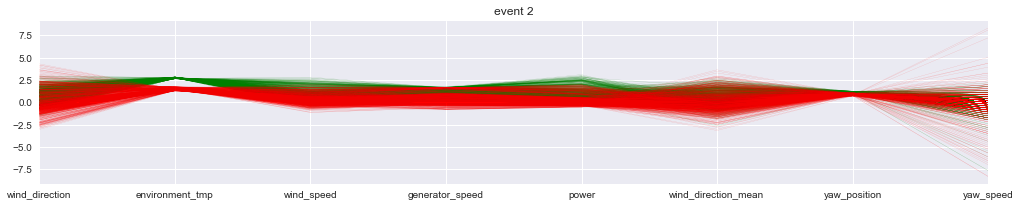

event: [2]


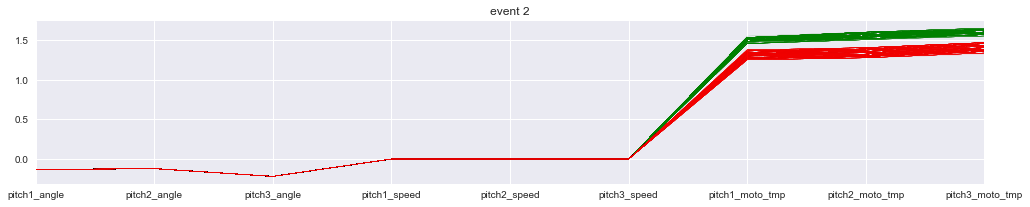

event: [2]


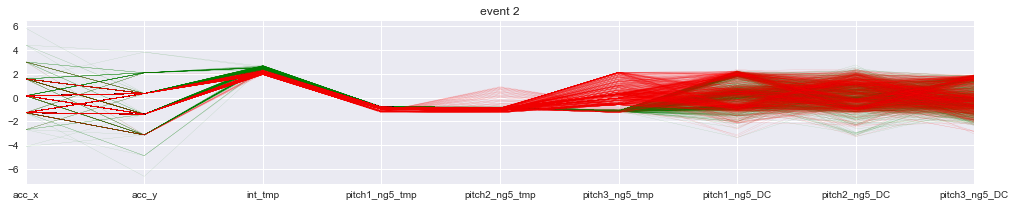

In [149]:
line_chart(data, 2, ['wind_direction','environment_tmp','wind_speed','generator_speed','power','wind_direction_mean','yaw_position','yaw_speed'])
line_chart(data, 2, ['pitch1_angle','pitch2_angle','pitch3_angle','pitch1_speed','pitch2_speed','pitch3_speed','pitch1_moto_tmp','pitch2_moto_tmp','pitch3_moto_tmp'])
line_chart(data, 2, ['acc_x','acc_y','int_tmp','pitch1_ng5_tmp','pitch2_ng5_tmp','pitch3_ng5_tmp','pitch1_ng5_DC','pitch2_ng5_DC','pitch3_ng5_DC'])


Summary: Suspect Variable: 
- 
- 
- 

- ** Trend Chart **  
觀察Failure前後的趨勢

event: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


/Users/jayhsu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,halflife=50).mean()


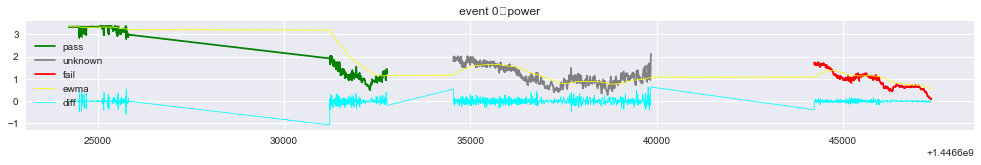

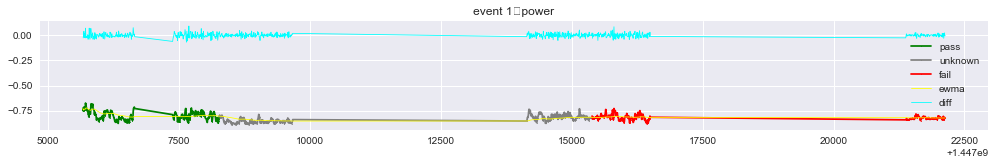

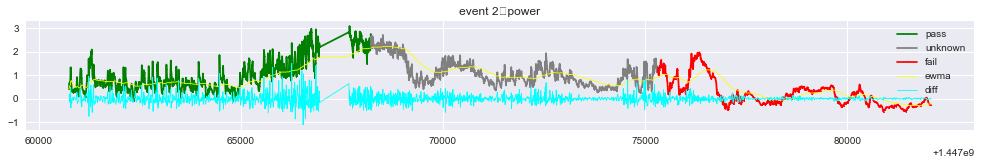

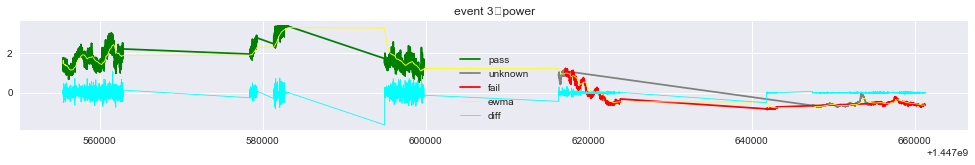

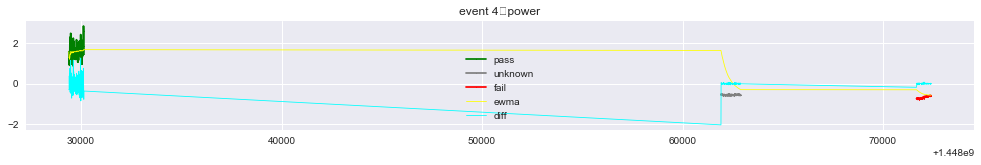

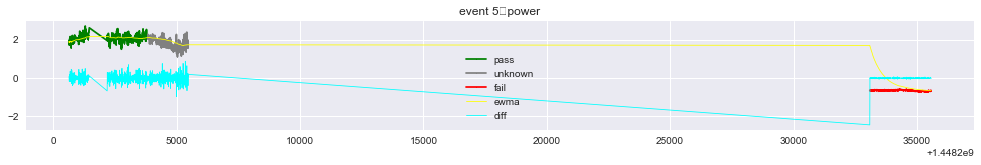

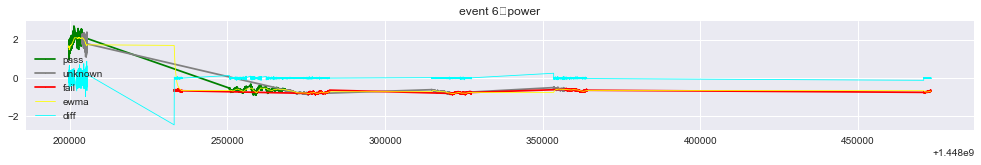

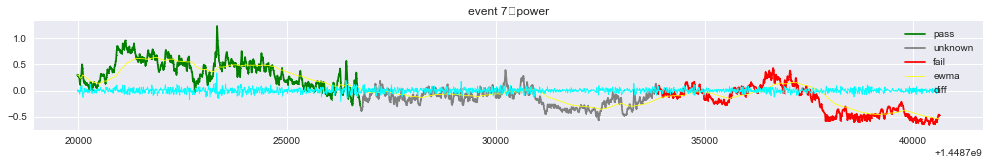

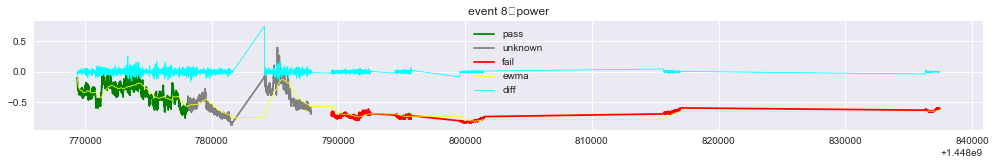

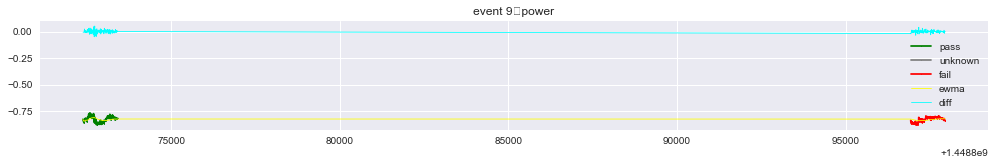

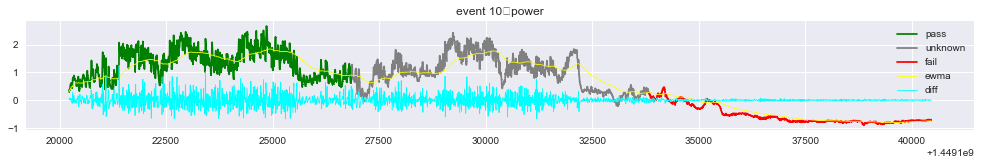

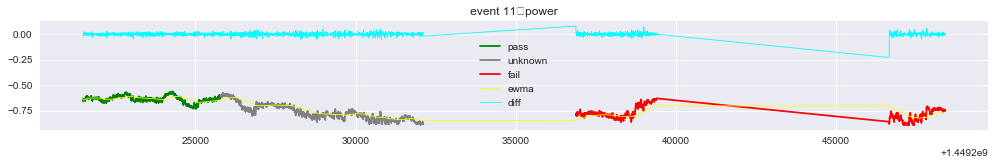

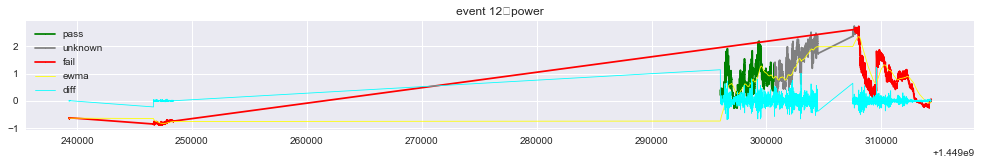

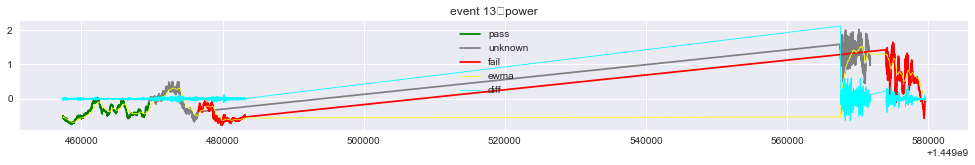

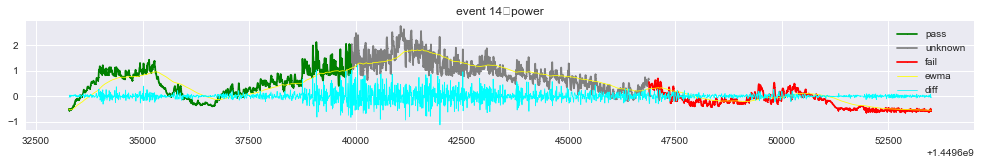

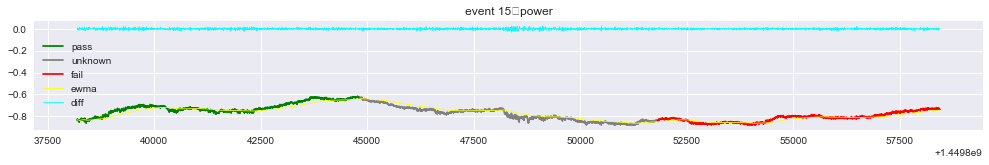

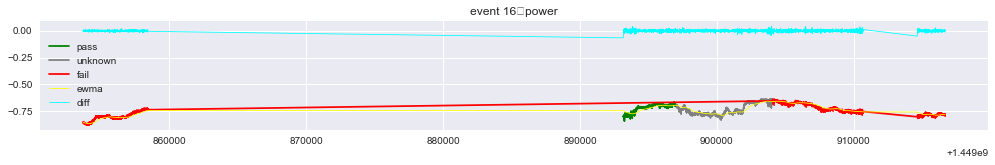

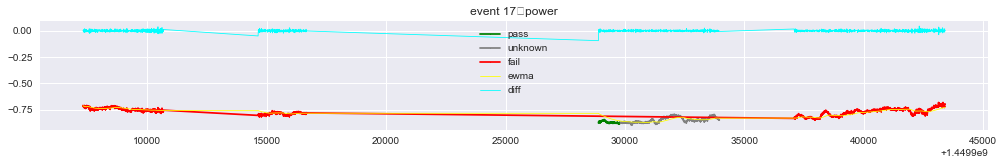

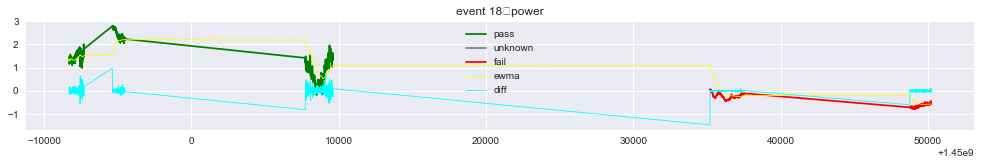

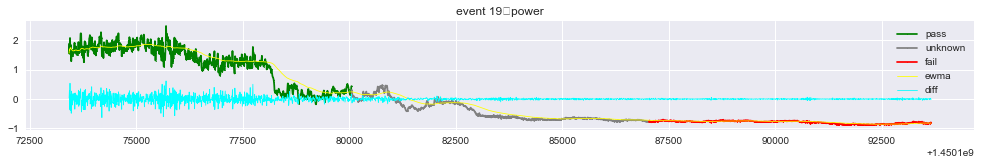

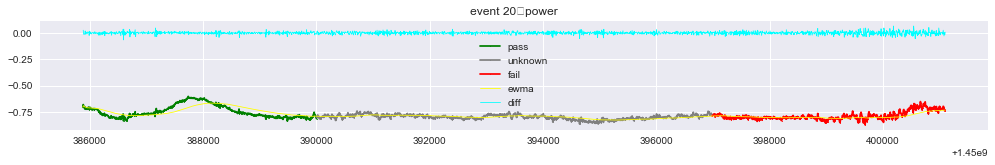

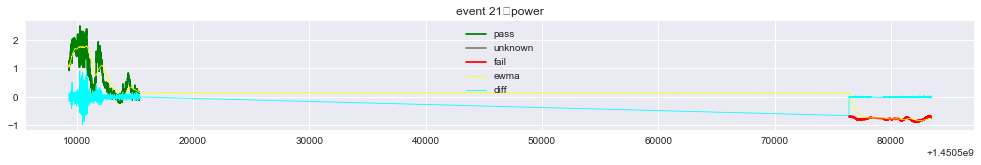

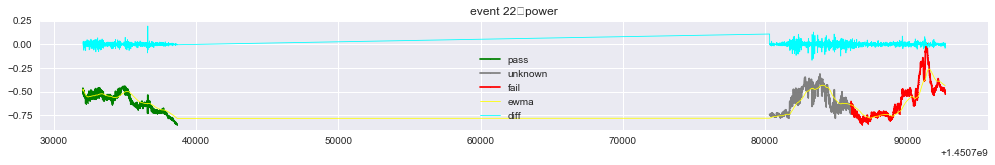

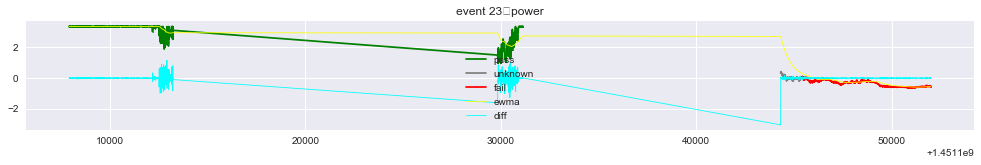

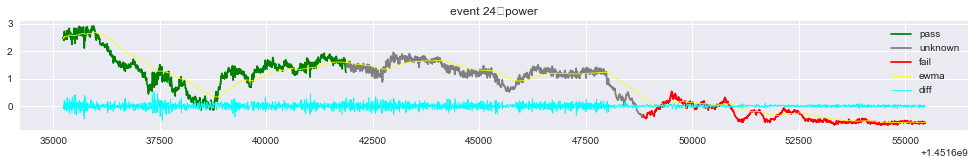

In [58]:
#'pitch1_moto_tmp', 'environment_tmp','int_tmp',
varlist = ['power']
trend_chart(data,events,varlist=varlist, split=False, ma=50)


**Observation: **  
- power ~= generator_speed
- wind_direction ~= wind_direction_mean
- pitch1_angle = pitch2_angle = pitch3_angle
- pitch1_speed = pitch2_speed = pitch3_speed
- pitch1_moto_tmp = pitch2_moto_tmp = pitch3_moto_tmp


**Summary: **  
- Attention:
    - machine: ['power', 'pitch1_angle',  'pitch1_speed', 'pitch1_moto_tmp','yaw_position']  
    - environment: ['wind_speed', 'wind_direction_mean', 'environment_tmp', 'int_tmp' ]
  
   
- redundancy:  
    - machine: ['generator_speed', 'pitch2_speed', 'pitch3_speed','pitch2_moto_tmp', 'pitch3_moto_tmp','pitch2_angle', 'pitch3_angle']  
    - environment: ['wind_direction']
  
  
- stable: 
    - machine: ['pitch1_ng5_DC','pitch2_ng5_DC', 'pitch3_ng5_DC','acc_x', 'acc_y','yaw_speed', 'pitch1_ng5_tmp','pitch2_ng5_tmp', 'pitch3_ng5_tmp']



In [119]:
suspect_vars = ['power', 'pitch1_angle',  'pitch1_speed','pitch1_moto_tmp','yaw_position'] + ['wind_speed', 'wind_direction_mean', 'environment_tmp', 'int_tmp' ]
suspect_vars


['power',
 'pitch1_angle',
 'pitch1_speed',
 'pitch1_moto_tmp',
 'yaw_position',
 'wind_speed',
 'wind_direction_mean',
 'environment_tmp',
 'int_tmp']

- ** distribution plot **  
進一步篩選能把Pass/Fail分開的Variables

In [121]:
dist_plot(data, event_id=events, varlist=['pitch1_angle','pitch2_angle','pitch3_angle'])


- ** Box Plot **

In [122]:
#sns.violinplot
#sns.barplot
box_plot(data, event_id=events, varx='label', varylist=['power','wind_speed','environment_tmp'],fun=sns.violinplot)

- ** Autocorrelation **

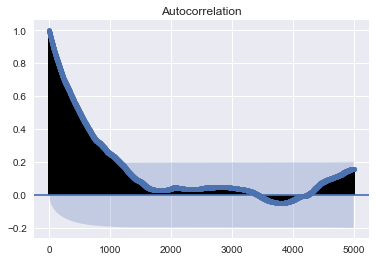

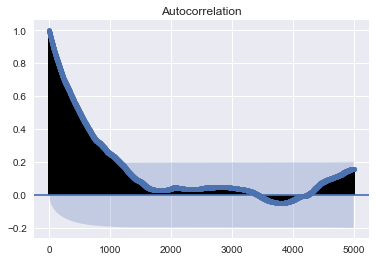

In [61]:
from statsmodels.graphics.tsaplots import plot_acf

power_wer = data['power']
plot_acf(power_wer,lags=5000)

Summary: Suspect Variables:   
-   
-  
-  

<a id='multi'></a>
** Multi-Variable Exploration **
- 挑出高度相關的Variables (heat map)
- 進一步篩選能把Pass/Fail分開的Variables (scatter plot)

- ** correlation heatmap **

<function matplotlib.pyplot.tight_layout>

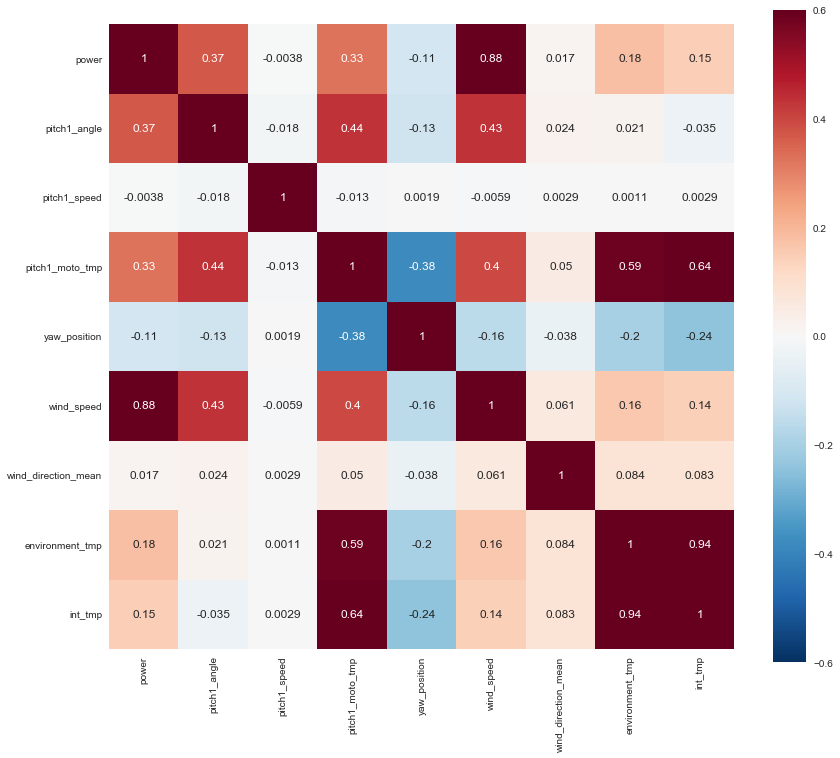

In [126]:
data_heatmap = data[suspect_vars]
plt.figure(figsize=(14,12))
foo = sns.heatmap(data_heatmap.corr(), vmax=0.6, square=True, annot=True)
plt.tight_layout

- ** Scatter Plot **

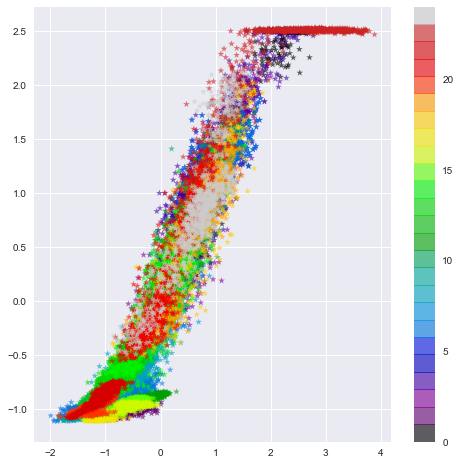

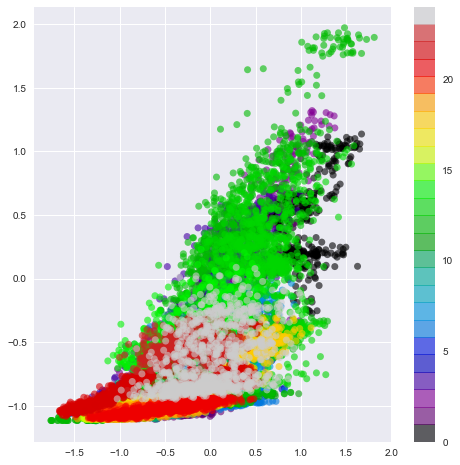

In [21]:
dummy = plt.figure(figsize=[8,8])
data_nor = data[data['label']==0]
plt.scatter('wind_speed', 'power', c='event', edgecolor='none', marker='*', alpha=0.6, data=data_nor,cmap=plt.cm.get_cmap('nipy_spectral', 25))
plt.colorbar()
dummy = plt.figure(figsize=[8,8])
data_abnor = data[data['label']==1]
plt.scatter('wind_speed', 'power', c='event', edgecolor='none', marker='o', alpha=0.6, data=data_abnor,cmap=plt.cm.get_cmap('nipy_spectral', 25))
plt.colorbar()

levels = [-0.5, 0.5 , 1.5]
colors = ['green', 'red']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
data_scatter = data[data['label']!=2]
for vary in suspect_vars:
    for varx in suspect_vars:
        if varx==vary:
            continue
        plt.scatter(varx, vary, c='label', edgecolor='none', marker='*', alpha=0.4, data=data_scatter,cmap=cmap, norm=norm)
        plt.colorbar()
        plt.xlabel(varx)
        plt.ylabel(vary)
        plt.show()


event: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


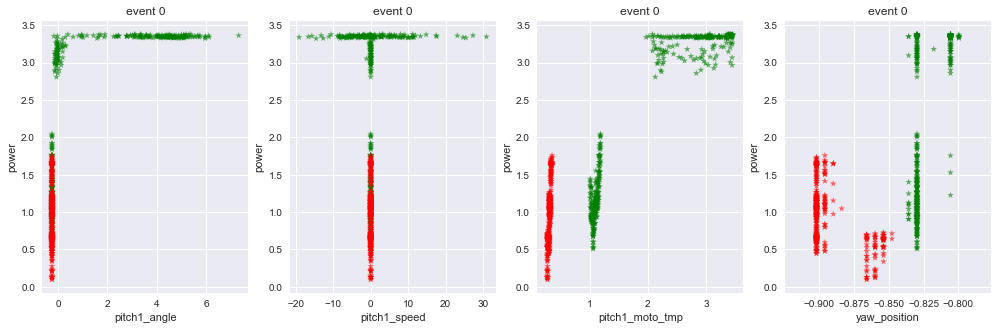

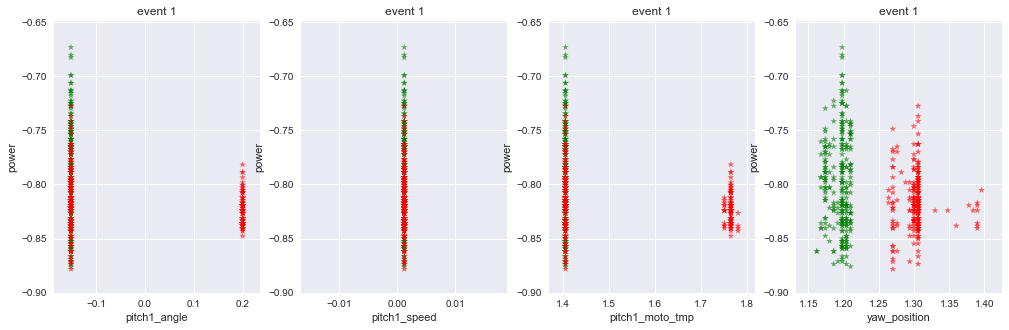

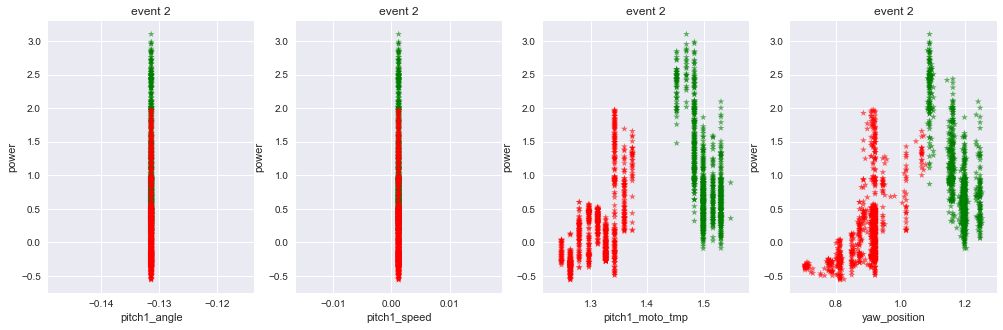

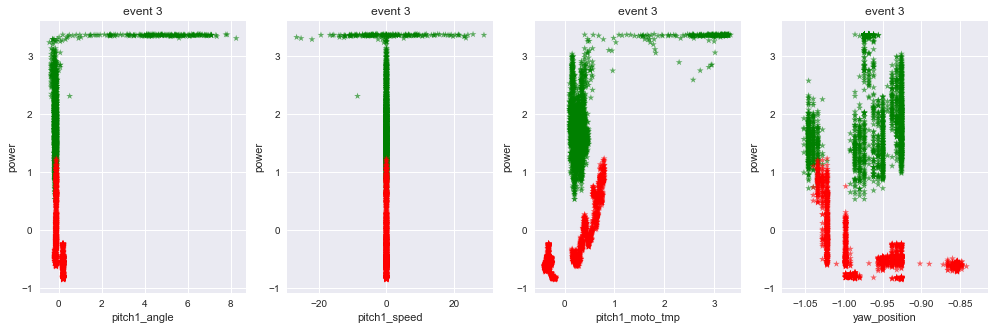

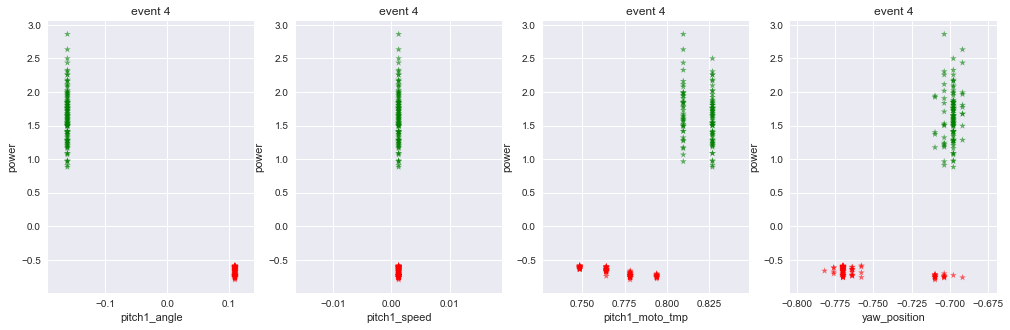

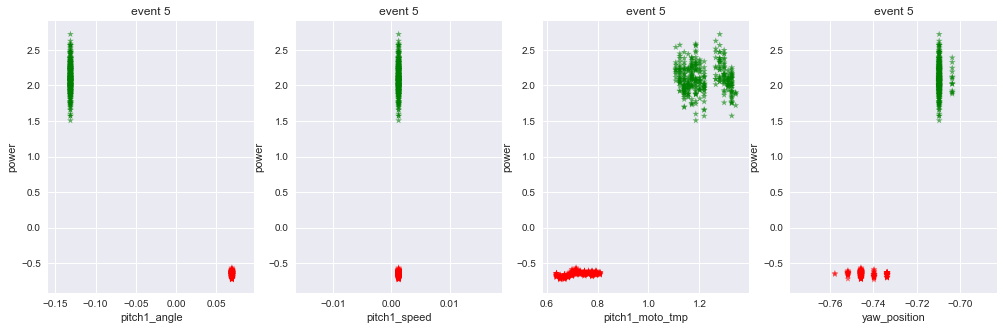

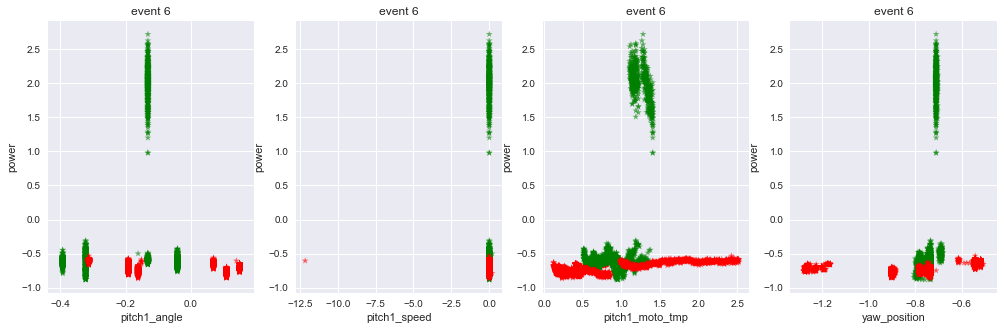

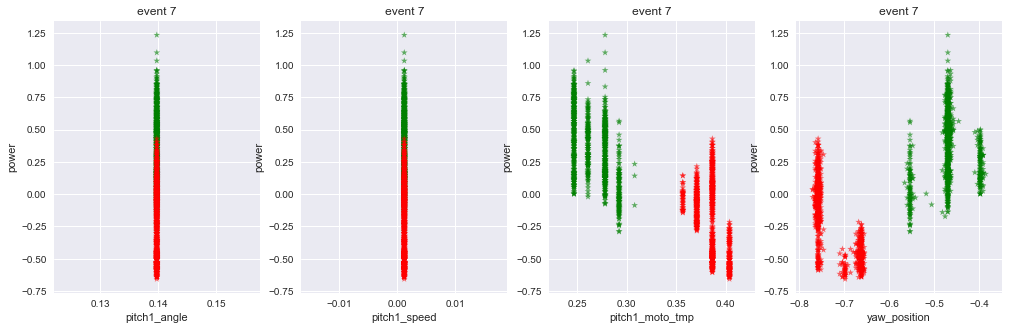

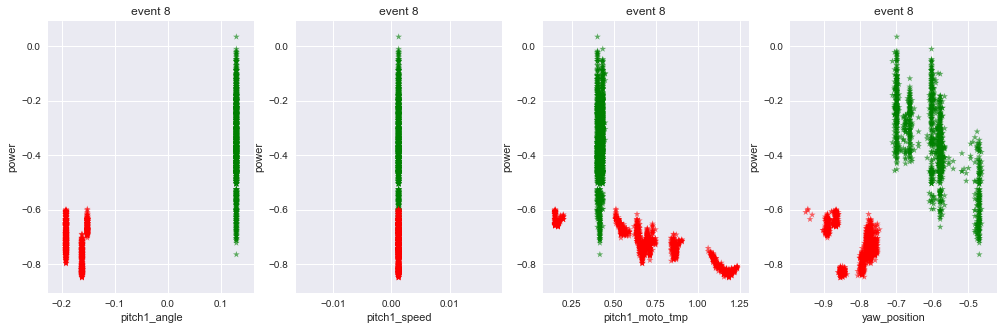

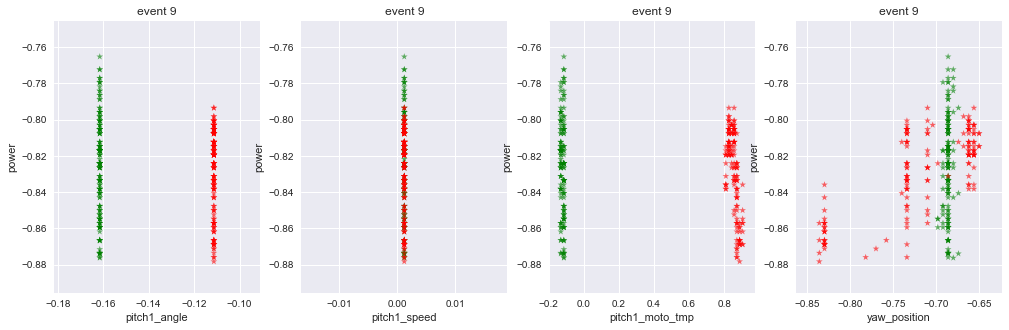

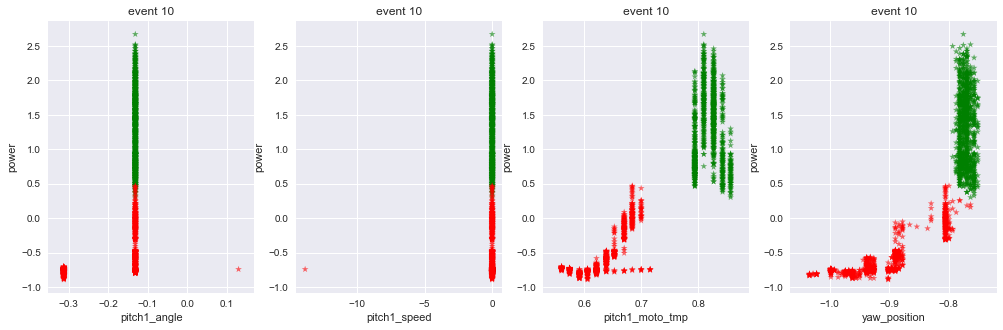

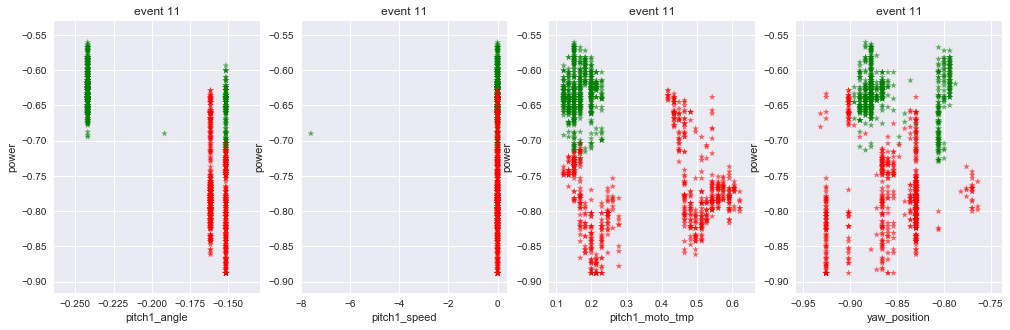

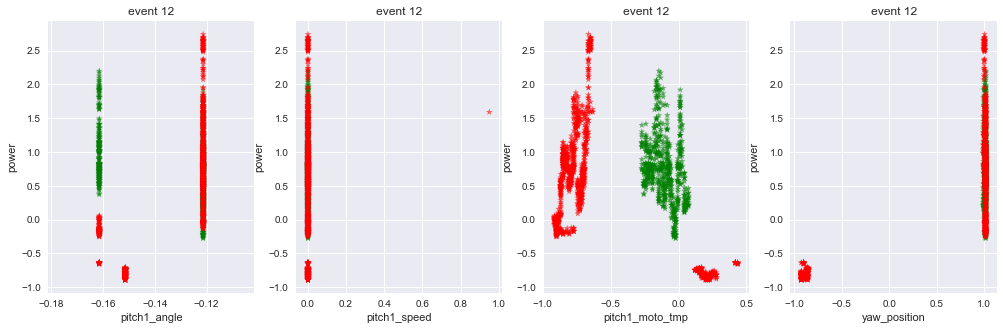

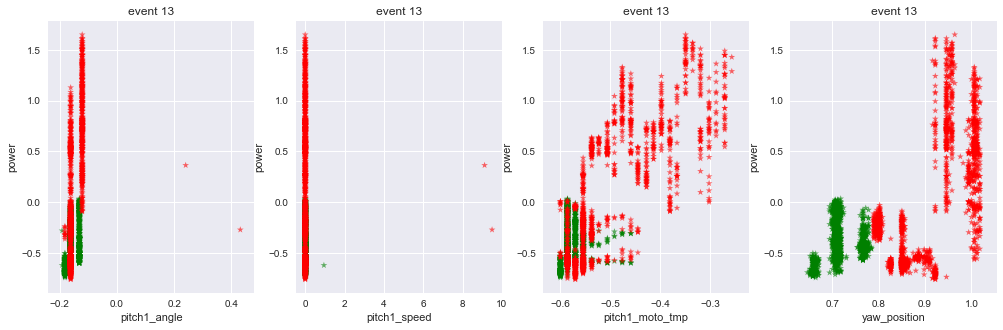

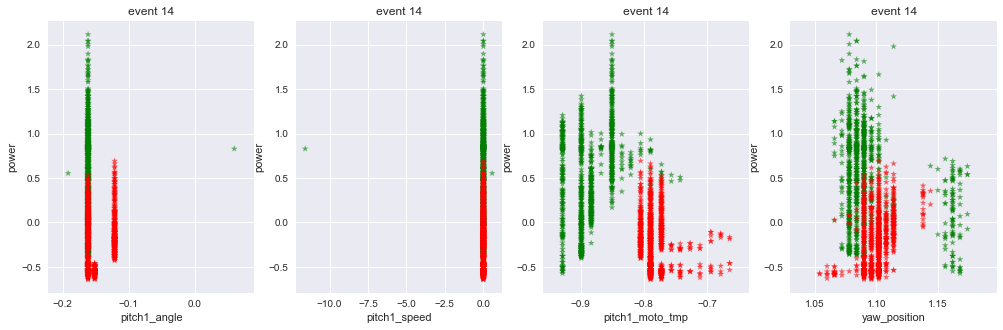

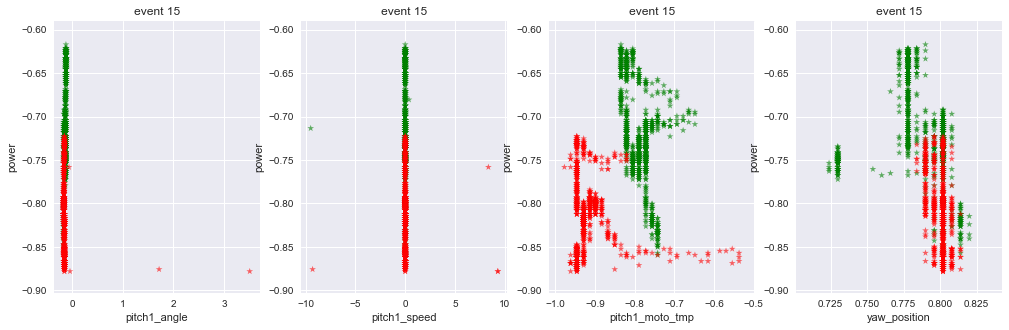

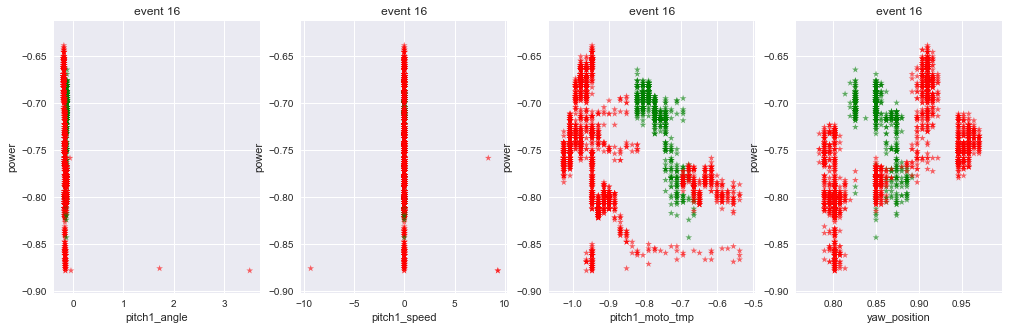

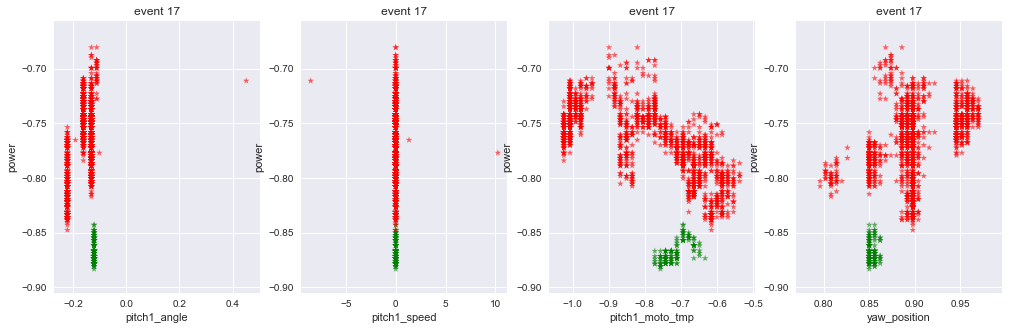

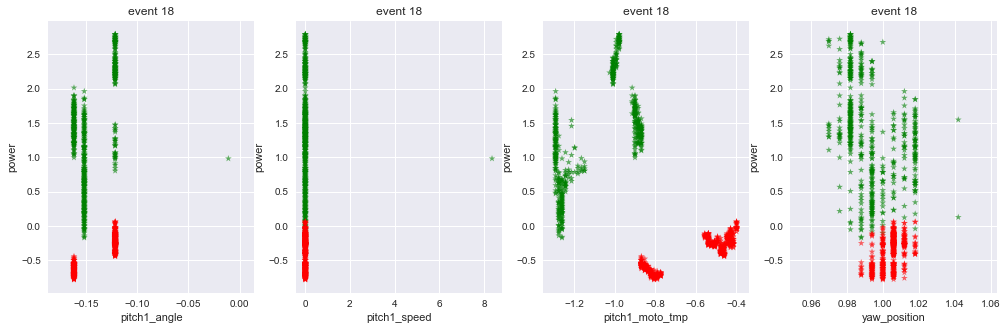

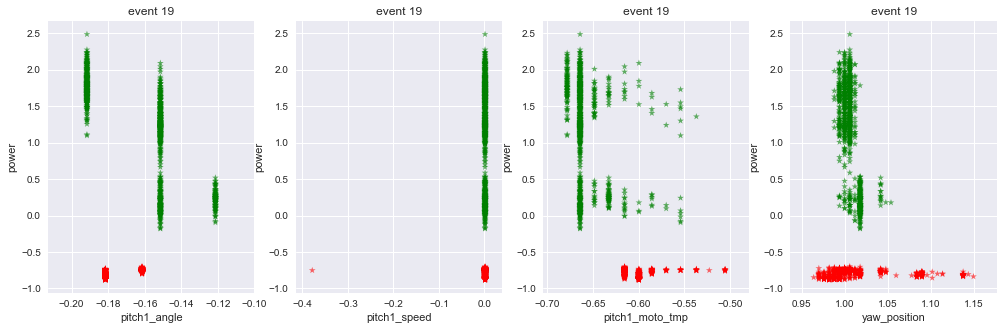

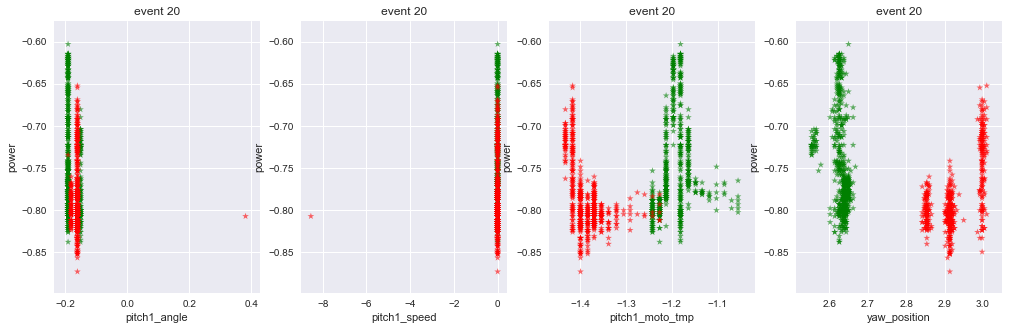

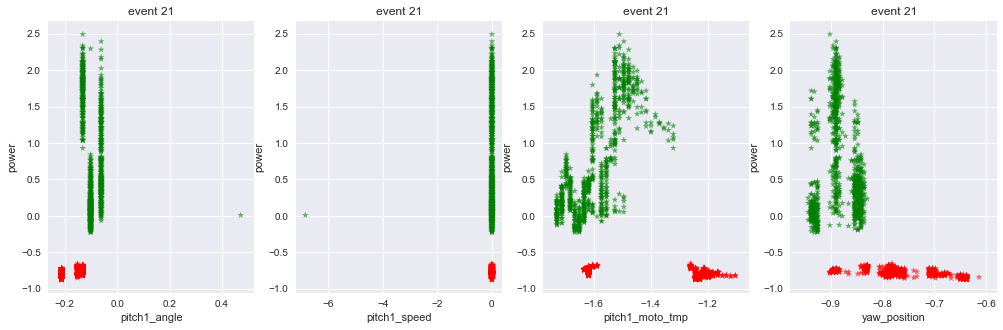

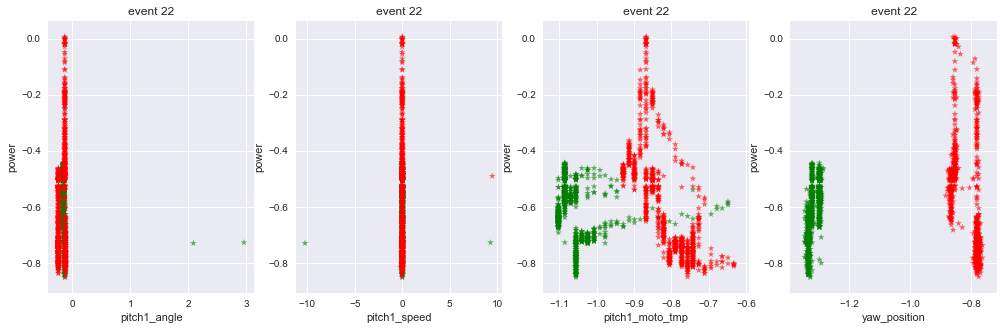

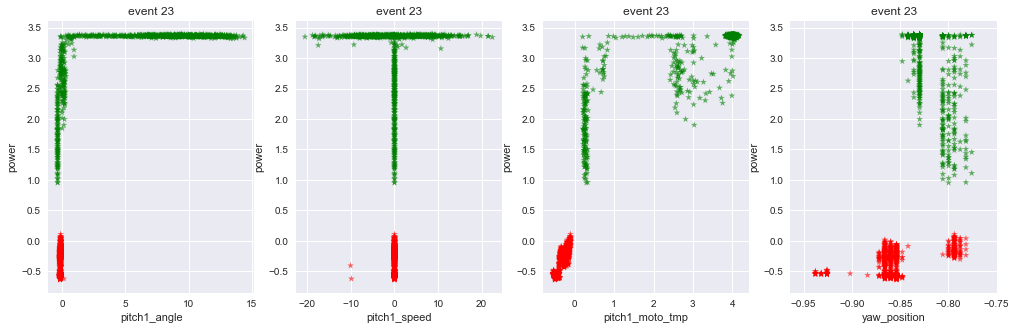

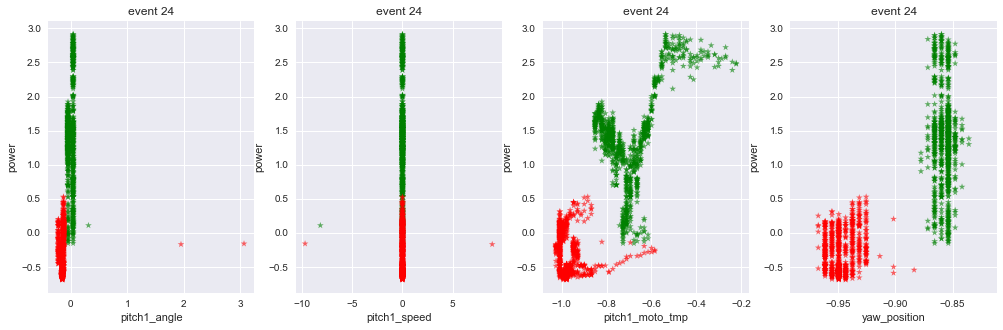

In [151]:

scatter_plot(data, event_id=events, vary='power', varxlist=['pitch1_angle','pitch1_speed','pitch1_moto_tmp','yaw_position'])




- ** Scatter 3D **

event: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


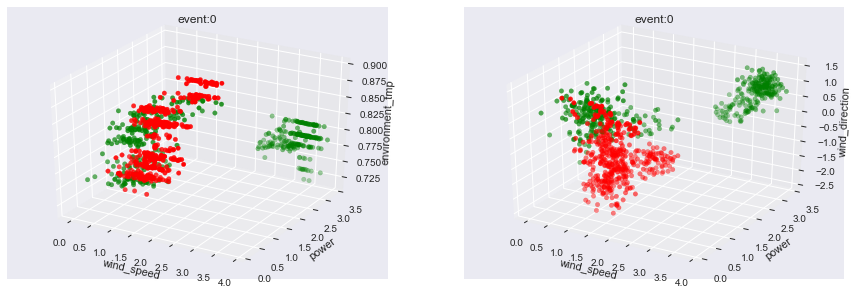

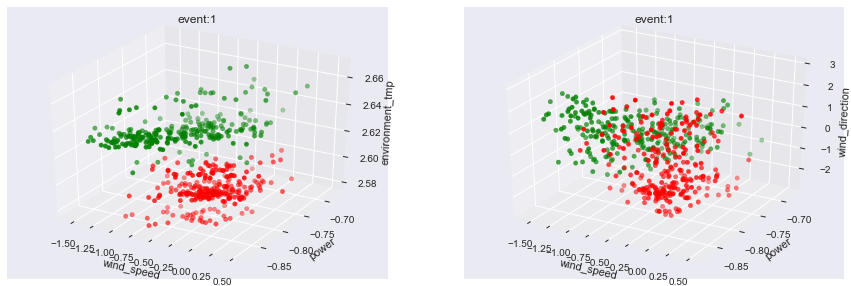

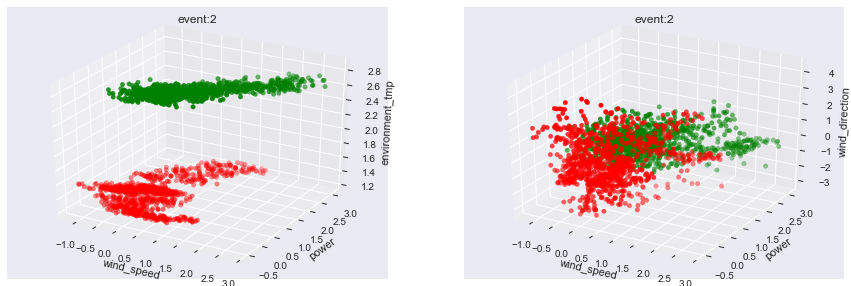

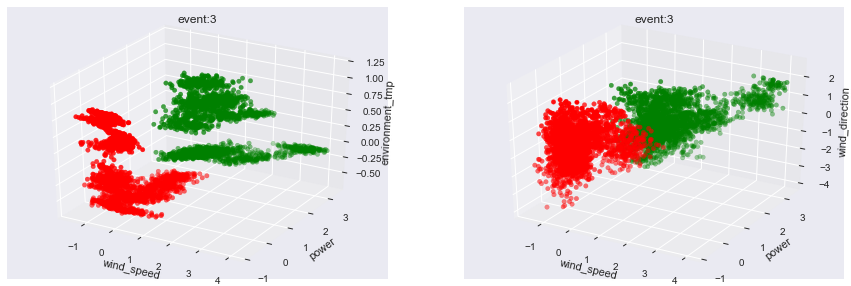

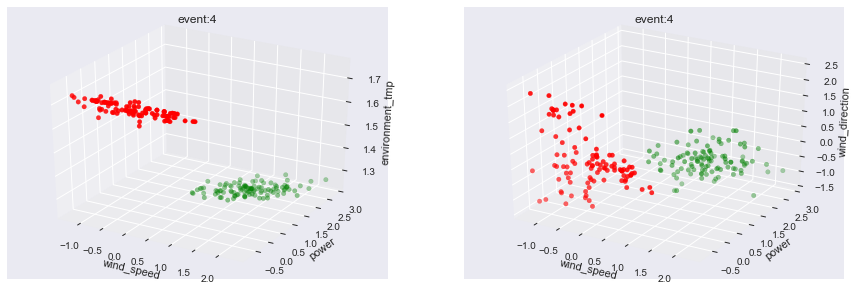

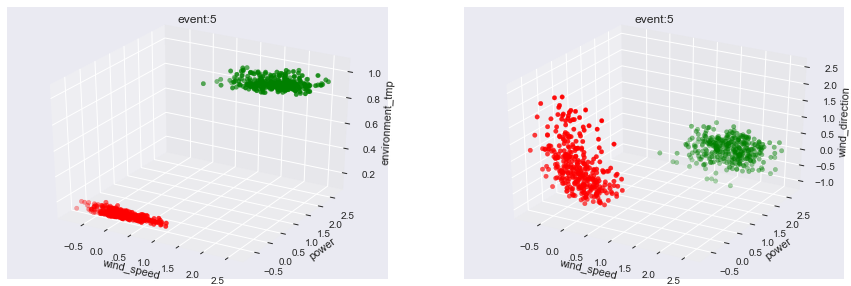

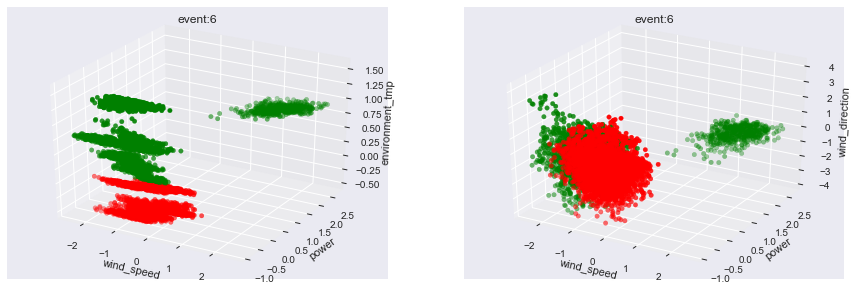

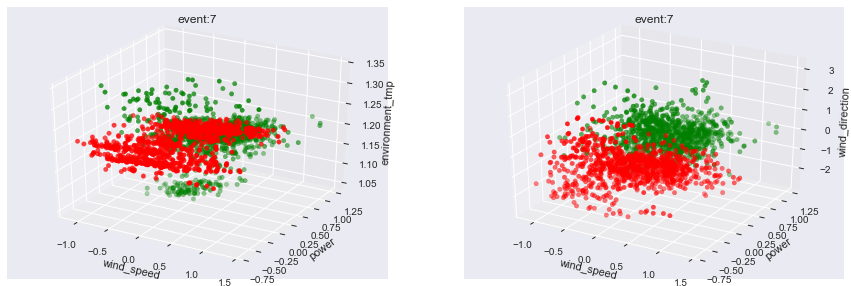

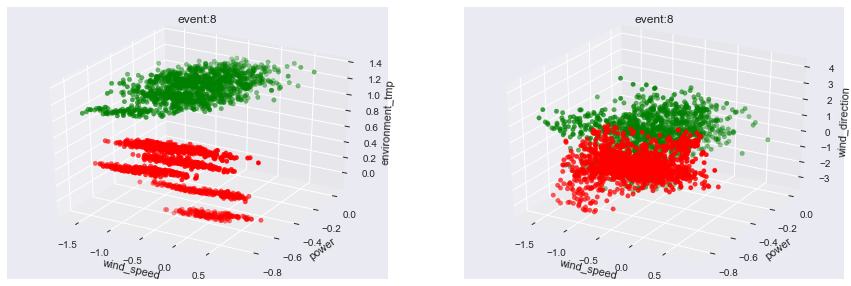

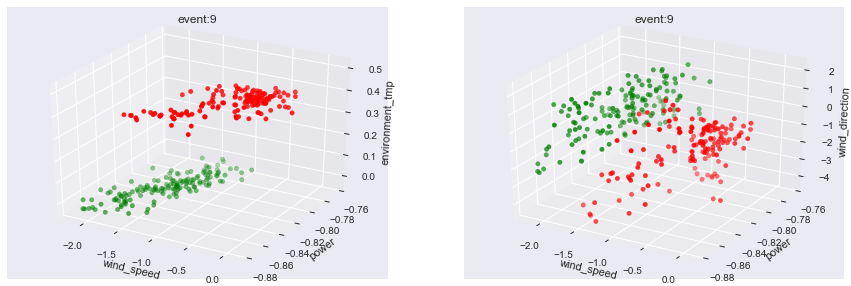

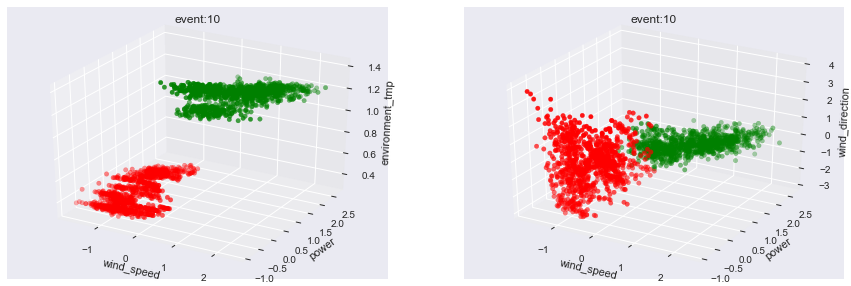

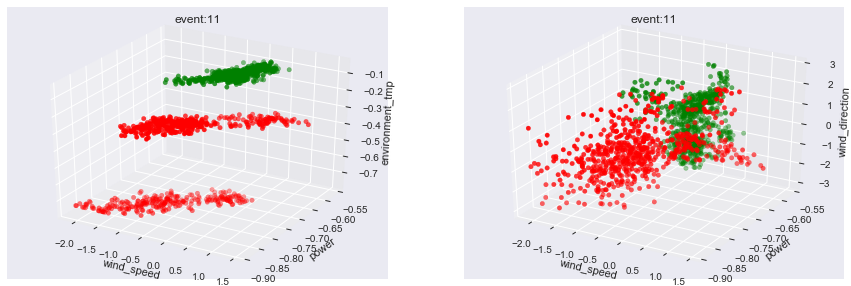

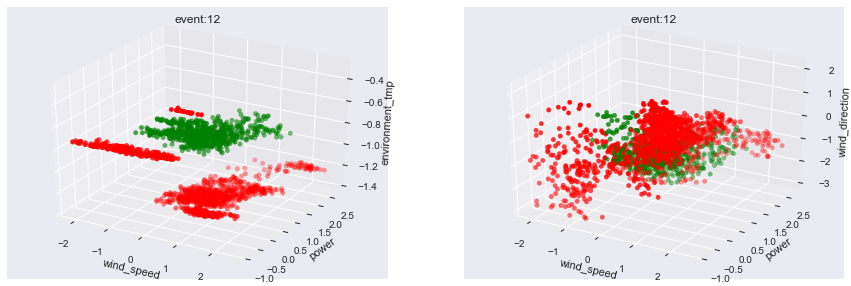

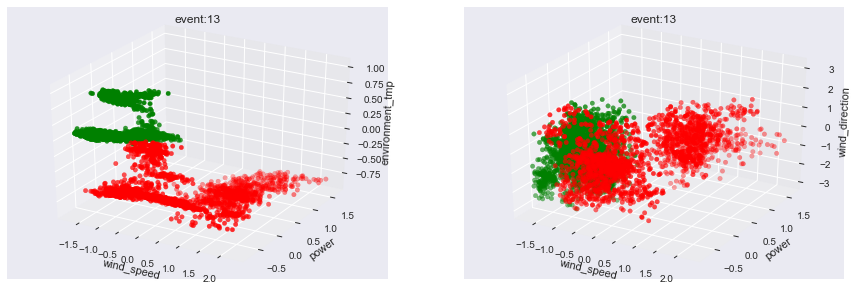

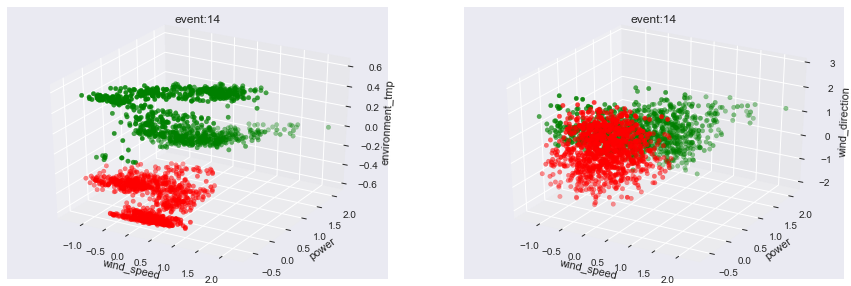

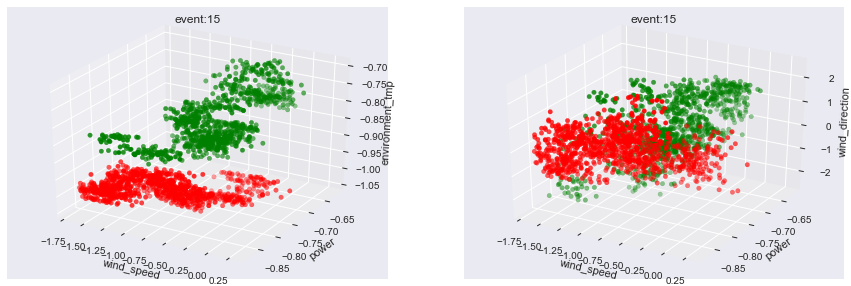

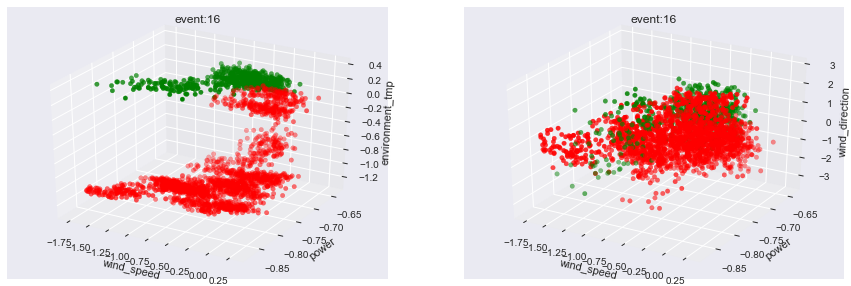

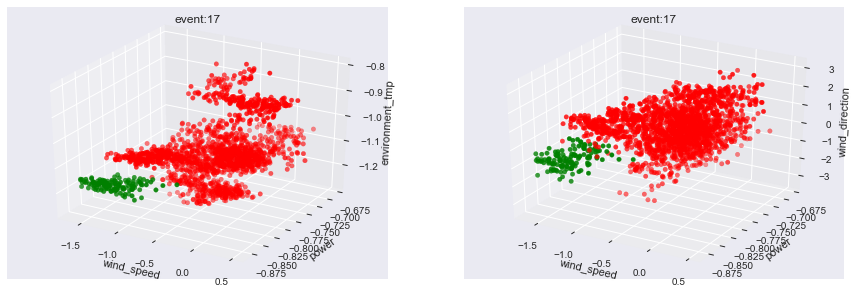

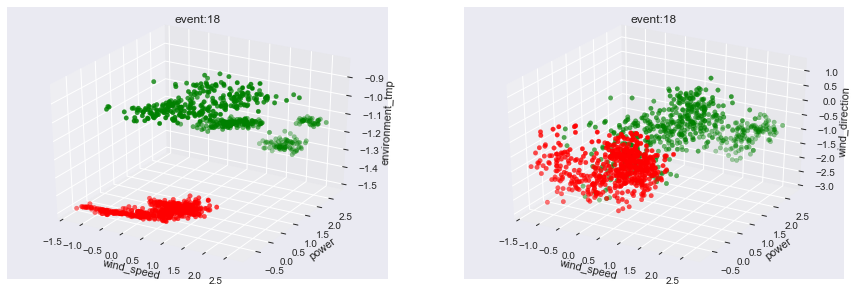

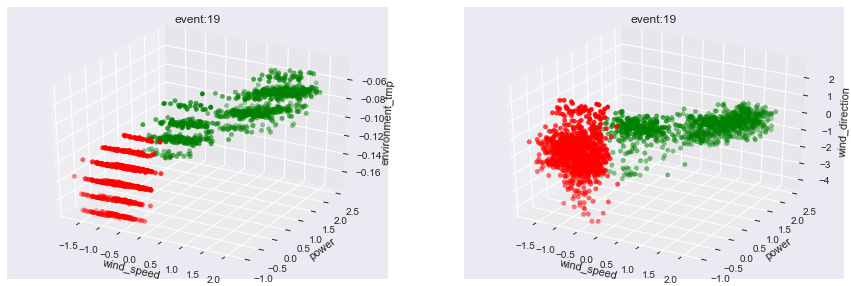

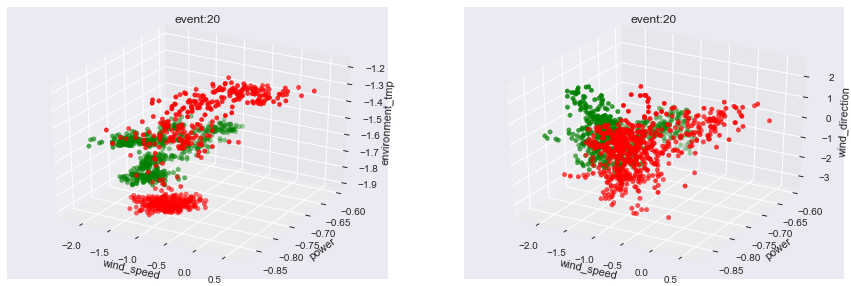

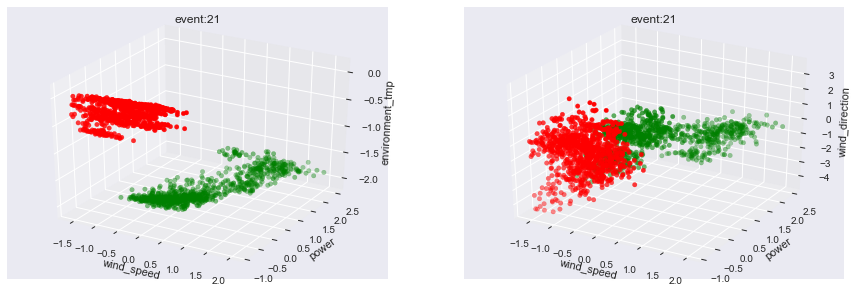

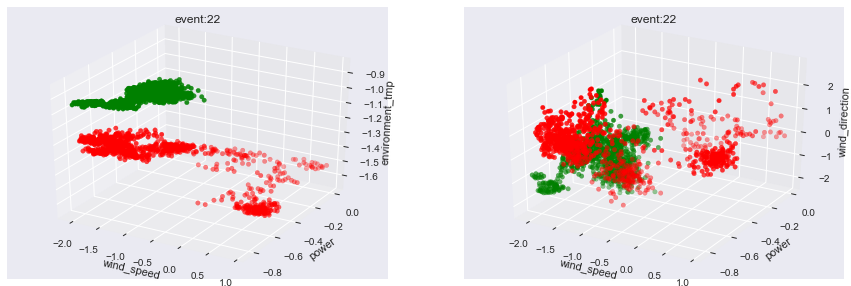

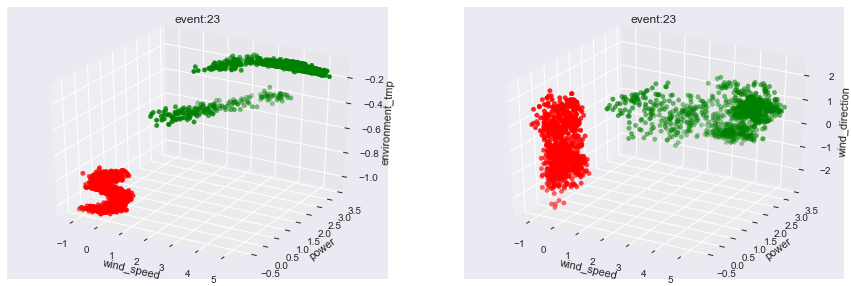

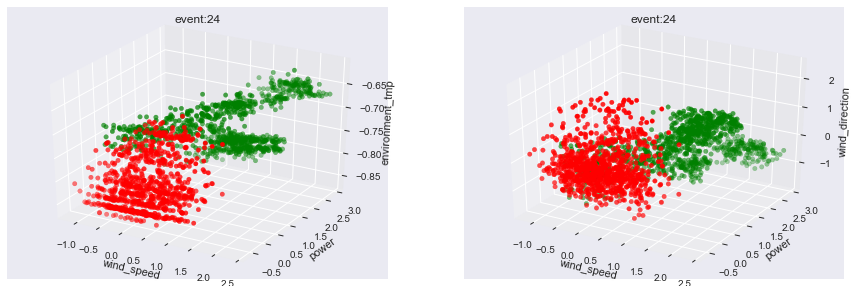

In [152]:
sactter_3d(data, event_id=events, varx='wind_speed', vary='power', varzlist=['environment_tmp','wind_direction'])

Summary: Suspect Variables:  
-  
-  
-  

<a id='dimen'></a>
** Dimension Reduction **
- ** PCA **

In [143]:
suspect_vars
data_pca = data[data['label']!=2]
label = data_pca['label']
data_pca = data_pca[suspect_vars]
pca = PCA(0.95)
data_proj = pca.fit_transform(data_pca)
print(data_pca.shape)
print(data_proj.shape)
pca.explained_variance_
pca.explained_variance_ratio_


['power',
 'pitch1_angle',
 'pitch1_speed',
 'pitch1_moto_tmp',
 'yaw_position',
 'wind_speed',
 'wind_direction_mean',
 'environment_tmp',
 'int_tmp']

(47554, 9)
(47554, 6)


array([ 3.31463392,  2.01176284,  1.40085771,  1.03179671,  0.92929752,
        0.81187333])

array([ 0.33518872,  0.20343731,  0.1416602 ,  0.10433931,  0.09397419,
        0.0820998 ])

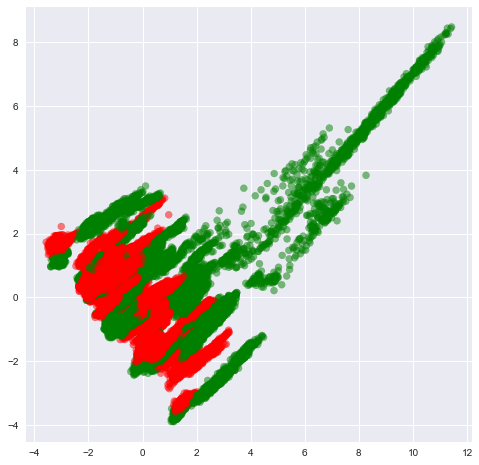

In [153]:
dummy = plt.figure(figsize=[8,8])
levels = [-0.5, 0.5 , 1.5]
colors = ['green', 'red']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
plt.scatter(data_proj[:, 0], data_proj[:, 1], c=label, alpha=0.5 , cmap=cmap, norm=norm)
